In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [2]:
# сгенерируем данные
classification_data, classification_labels = make_classification(n_samples=1500, n_features=2, n_informative=2,
                                                                 n_classes=2, n_redundant=0,
                                                                 n_clusters_per_class=1, random_state=5)

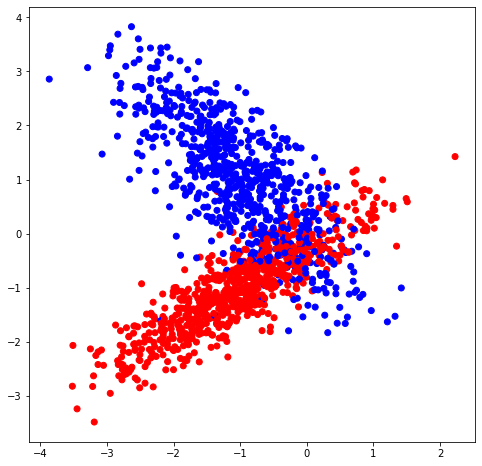

In [3]:
# визуализируем сгенерированные данные
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
              c=classification_labels, cmap=colors);

In [4]:
# Реализуем класс узла
class Node:
    def __init__(self, index, threshold, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.threshold = threshold  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [5]:
# И класс терминального узла (листа)
class Leaf:
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1

        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [6]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [7]:
# Расчет прироста
def gain(left_labels, right_labels, root_gini):

    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [8]:
# Разбиение датасета в узле
def split(data, labels, column_index, cond):

    left = np.where(data[:, column_index] <= cond)
    right = np.where(data[:, column_index] > cond)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):

    #  обозначим минимальное количество объектов в узле
    min_samples_leaf = 5

    root_gini = gini(labels)

    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_samples_leaf or len(false_data) < min_samples_leaf:
                continue

            current_gain = gain(true_labels, false_labels, root_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):

    gain_inf, threshold, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain_inf == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, threshold)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, threshold, true_branch, false_branch)

In [11]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer
    
    if obj[node.index] <= node.threshold:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [12]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [13]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index), '<=', str(node.threshold))

    # Рекурсивный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсивный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [14]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [15]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))


def visualize(train_values, test_values):
    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_values)
    mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_values[:, 0], train_values[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_values[:, 0], test_values[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [16]:
# Разобьем выборку на обучающую и тестовую
train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.3,
                                                                    random_state=1)

### Задача 1
В коде из методички реализуйте один или несколько из критериев останова (количество листьев, количество используемых признаков, глубина дерева и т.д.)

Добавил ограничение на глубину дерева

In [17]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels, max_depth=np.inf, depth=0):

    gain_inf, threshold, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if gain_inf == 0:
        return Leaf(data, labels)
    
    # Если текущая глубина больше или равна максимальной возвращаем лист
    if depth >= max_depth:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, threshold)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, max_depth=max_depth, depth=depth+1)
    false_branch = build_tree(false_data, false_labels, max_depth=max_depth, depth=depth+1)


    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, threshold, true_branch, false_branch)

In [18]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, max_depth=4)
print_tree(my_tree)

Индекс 1 <= -0.22948985019950252
--> True:
  Индекс 0 <= -0.3469447558400549
  --> True:
    Индекс 1 <= -0.5226940877264623
    --> True:
      Индекс 0 <= -0.6939010330955526
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
    --> False:
      Индекс 1 <= -0.3408665844165093
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 0
  --> False:
    Индекс 1 <= -0.8408009227563504
    --> True:
      Индекс 0 <= 0.0792849189708209
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Индекс 0 <= 0.6315094749990133
      --> True:
        Прогноз: 0
      --> False:
        Прогноз: 1
--> False:
  Индекс 0 <= 0.28954698397908096
  --> True:
    Индекс 1 <= 0.21327675812621738
    --> True:
      Индекс 0 <= -0.6158951979035864
      --> True:
        Прогноз: 1
      --> False:
        Прогноз: 1
    --> False:
      Индекс 0 <= -0.22345581847953377
      --> True:
        Прогноз: 1
      --> False:
        Прог

In [19]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

90.66666666666666

In [20]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

88.88888888888889

<ipython-input-15-fe63e7f45c98>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-15-fe63e7f45c98>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


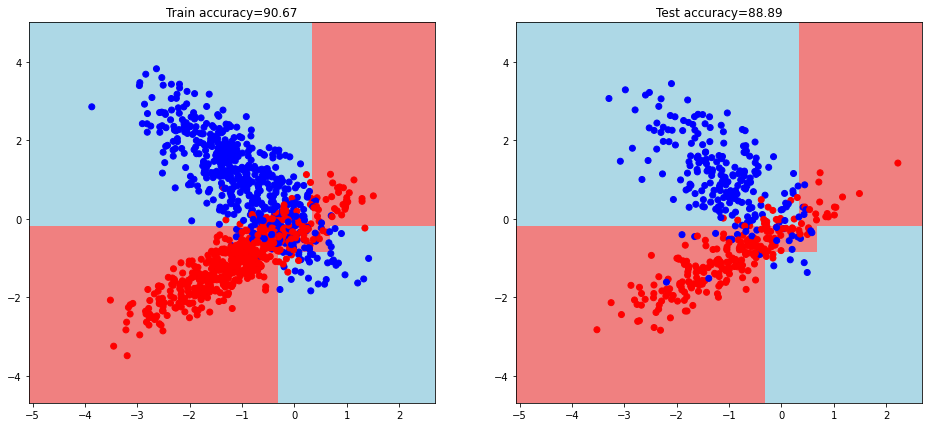

In [21]:
visualize(train_data, test_data)

In [22]:
my_tree = build_tree(train_data, train_labels, max_depth=1)
print_tree(my_tree)

Индекс 1 <= -0.22948985019950252
--> True:
  Прогноз: 0
--> False:
  Прогноз: 1


In [23]:
# Получим ответы для обучающей выборки
train_answers = predict(train_data, my_tree)
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

85.04761904761905

In [24]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

86.0

<ipython-input-15-fe63e7f45c98>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
<ipython-input-15-fe63e7f45c98>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)


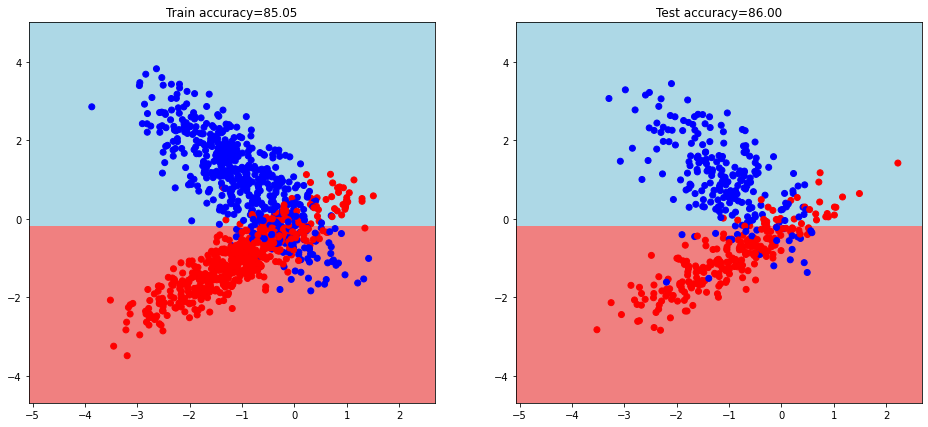

In [25]:
visualize(train_data, test_data)

### Задача 2*
Реализуйте дерево для задачи регрессии. Возьмите за основу дерево, реализованное в методичке, заменив механизм предсказания в листе на взятие среднего значения по выборке, и критерий Джини на дисперсию значений.